# EITP40 Lab 3: Tiny Machine learning on IoT Devices

In Lab 1 and Lab 2, you implemented machine learning models with Keras to run in your computer. In this lab, you will take these learnings and do inference on an Arduino Nano 33 BLE Sense with a fraction of the computing power!

If you are running this notebook in the computer lab, the installed packages may not persist. Uncomment the line below, run the cell to install packages then restart the Python kernal.

In [5]:
!pip install tinymlgen

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tinymlgen: filename=tinymlgen-0.2-py3-none-any.whl size=2225 sha256=804d92dd506d7074d488a5db9146c45f87b4675ff52622ca2168adbc6c3cbb03
  Stored in directory: /Users/antoniokrsoski/Library/Caches/pip/wheels/0c/46/2e/f10b7800fba560246b2c0f4317010a8c40ae3999f457a59efc
  Created wheel for hexdump: filename=hexdump-3.3-py3-none-any.whl size=8893 sha256=8b6209a04d6436528d363298f52494880c070e2c8c18e80f6a52808687cf94ee
  Stored in directory: /Users/antoniokrsoski/Library/Caches/pip/wheels/5e/b9/b5/227a20e7e8bbdb2b17e46a087c0f0119059ee65fe8374cac18
Successfully built tinymlgen hexdump

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


To open JupyterLab with access to your directories, open anaconda and enter the command `jupyter lab --notebook-dir=H:`. Meanwhile, take a look at the learning objectives to see what you will learn by the end of this lab 😊!

## Learning Objectives

<div class="alert alert-success">
<p>By the end of this Lab, you will:</p>
<ul>
<li>Prepare and train a machine learning model on your PC using the CHB-MIT EEG dataset (data exploration, train/validation/test splits, normalisation, and model training)</li>
<li>Optimize a neural network architecture for deployment on resource-constrained microcontrollers (understanding memory limitations and creating lightweight models)</li>
<li>Deploy the trained model to an Arduino Nano 33 BLE Sense by converting it to embedded C code and running inference on the device</li>
</ul>
</div>

This Lab has two parts. In the first section, we will explore the dataset on the PC and go through the complete model creation process. Then, in the second part we will take the learnings and adjust our model to run on the Arduino Nano 33 BLE Sense.



## PC

In this section, we will explore the dataset and implement the model on the PC. To begin, make sure we have all the required libraries. 

In [1]:
import numpy as np
import tensorflow as tf
import visualkeras
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

- `numpy` -> Short for "**Num**erical **Py**thon", is a high performance Python library for handling matrices. 
- `tensorflow` ->  Deep learning library, developed by Google
- `visualkeras` -> Lightweight visualization tool for Keras models
- `matplotlib.pyplot` -> MATLAB-like plotting API from the Matplotlib library used to create figures and visualisations (line plots, histograms, subplots, etc.). Here we use via the alias `plt`.
- `sklearn` -> Machine learning library, with lots of helpful auxillary functions. Here, we only use the `train_test_split` method. 

### Exploring the Dataset

For Lab 3, you will use a subset of the CHB-MIT Scalp EEG dataset. This is already prepared for you in the `dataset/Category.npy` and `dataset/EEG.npy` Numpy arrays. If you get an error, make sure that the path is correct.

<div class="alert alert-info">
📝 <b>TODO:</b> Ensure that the EEG dataset and labels are accessible.
</div>

In [2]:
x = np.load('./EEG.npy')      # EEG data
y = np.load('./Category.npy') # Category labels


We can evalaute the shape of the two Numpy objects.

In [3]:
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

Shape of x: (248, 1024)
Shape of y: (248,)


The `x` object includes 248 EGG segments, each with 1024 samples. For each of the segments, `y` provides a value stating if it is a seizure `1` or non seizure `0` event. Sample 10 is an example of a seizure event, while sample 30 is an example of a non seizure event.

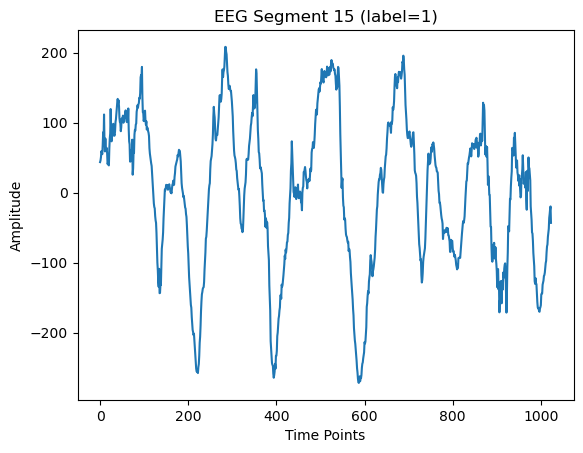

In [4]:
sampleID = 15

plt.plot(x[sampleID])
plt.title(f"EEG Segment {sampleID} (label={int(y[sampleID])})")
plt.xlabel("Time Points")
plt.ylabel("Amplitude")
plt.show()

To check if the data is normalised, we can see what the mean of the dataset is. 

In [5]:
print("Global mean:", x.mean())

Global mean: 0.12331096882508104


While the dataset as a whole might have a balanced amplitude, this is not the case for each sample as we can see below. 

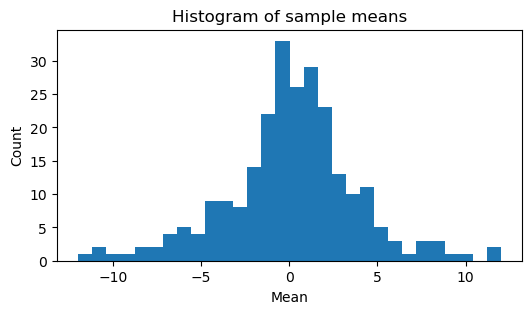

In [6]:
sample_means = x.mean(axis=1) # compute the mean across the 1024 time points for each sample

plt.figure(figsize=(6,3))
plt.hist(sample_means, bins=30)
plt.title("Histogram of sample means")
plt.xlabel("Mean")
plt.ylabel("Count")
plt.show()

We can see that the samples are not normalised, as the means of individual segments vary significantly, even though the overall dataset mean is close to zero. We will perform normalisation in the next section, after creating the training splits.

### Data Preprocessing (Split and Normalisation)

We call `train_test_split` from the (`sklearn` library) to split the original dataset into training set (60%), validation set (20%) and test set (20%).

<div class="alert alert-info">
📝 <b>TODO:</b> Create the test/train/validation split
</div>

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2) # 20% test set
x_train, x_val, y_train, y_val  = train_test_split(x_train, y_train, train_size=0.8, test_size=0.2) # 20% validation set from remaining 80%

print("Training set shape  :", x_train.shape)
print("Validation set shape:", x_val.shape) 
print("Test set shape      :", x_test.shape)

Training set shape  : (158, 1024)
Validation set shape: (40, 1024)
Test set shape      : (50, 1024)


In order to perform feature normalisation, we subtract the training set mean from the training, validation and test dataset. By using only the training set to calculate the mean and standard deviation, we avoid the issue of data snooping. 

$$
x_{train}^{(i,j)} = \frac{x^{(i,j)} - \bar{x}_{train}}{\sigma_{train}}
$$

where $x_{train}^{(i,j)}$ is the standardised value for the $i$-th training example and the $j$-th feature (time point, out of 1024), $x^{(i,j)}$ is the original raw value before standardization, $\bar{x}_{train}$ represents the global mean (average) of all values across all training examples and all features, and $\sigma_{train}$ is the global standard deviation across all training examples and all features.

<div class="alert alert-info">
📝 <b>TODO:</b> Implement feature normalisation for x_train, x_val and x_test
</div>

In [8]:
## scalar value
std_x   = np.std(x_train)
mean_x  = np.mean(x_train)

print("Global training set mean before normalization:", mean_x)
print("Global training set std before normalization:", std_x)

x_train = np.array([(x - mean_x) / std_x for x in x_train])
x_val   = np.array([(x - mean_x) / std_x for x in x_val])
x_test  = np.array([(x - mean_x) / std_x for x in x_test])

std_x = np.std(x_train)
mean_x  = np.mean(x_train)

print(std_x)
print(mean_x)

Global training set mean before normalization: -0.11918285652462937
Global training set std before normalization: 86.5428006219849
1.0000000000000002
-6.587557503709394e-18


### Build the Model

We will now create a fully connected model in Keras. Note, that since we used `import tensorflow as tf`, we should access the Keras module by calling `tf.keras`.

<div class="alert alert-info">
📝 <b>TODO:</b> Design the Keras neural model architecture. Layer should use SoftMax
</div>

In [9]:
model_fc = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1024,)), 
    tf.keras.layers.Reshape((1024, 1)),  # Reshape 1D input to (1024, 1) for Conv1D
    
    tf.keras.layers.Conv1D(32, 5, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv1D(64, 5, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.GlobalAveragePooling1D(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

model_fc.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Visualisation

We can also visualise `model_fc` using the `visualkeras` package.

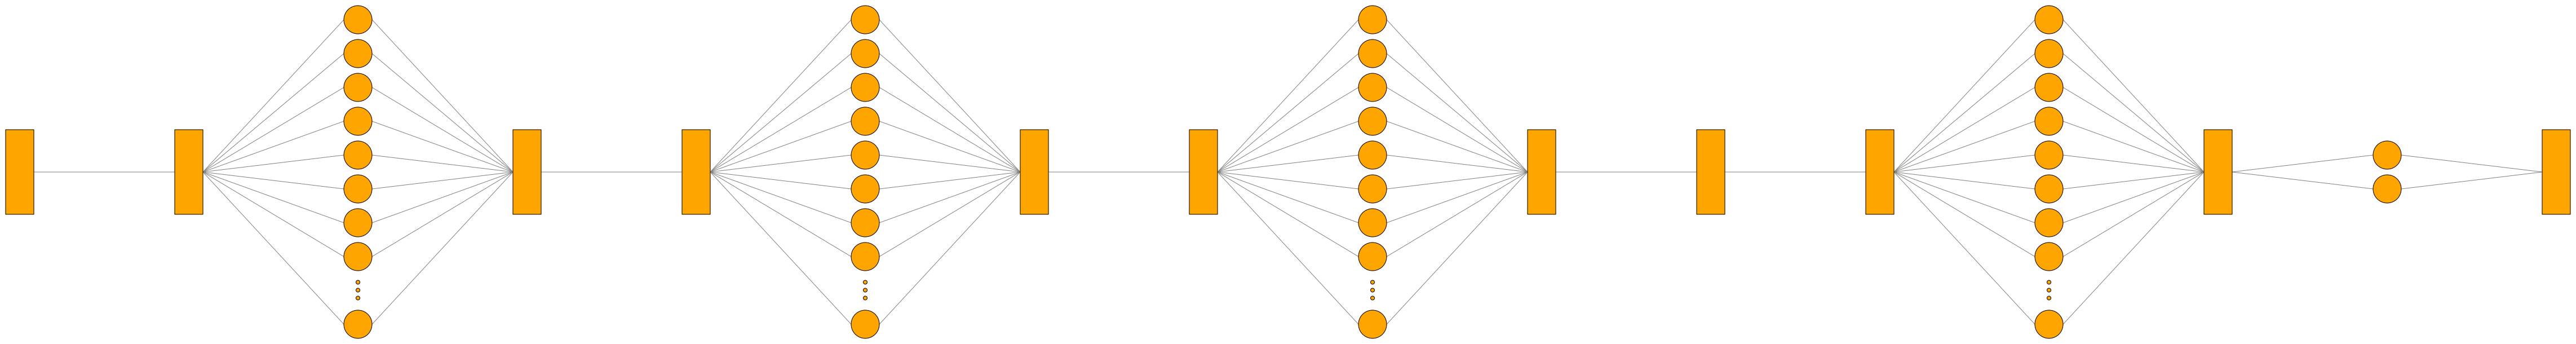

In [10]:
# Visualise the Keras model using visualkeras
visualkeras.graph_view(model_fc)

### Model training

`model_fc` will learn to classify EEG segments as seizure or non-seizure events. After training, we evaluate the model on the test set `x_test` to get an unbiased estimate of its performance on completely unseen data.

In [11]:
#  train the model
history = model_fc.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=16, epochs=40)
score = model_fc.evaluate(x_test, y_test, verbose=0)
print('The accuracy is ' + str(score[1]))
# save the model
model_fc.save('./model.h5')

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7591 - loss: 0.4362 - val_accuracy: 0.8750 - val_loss: 0.6245
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8962 - loss: 0.2668 - val_accuracy: 0.9000 - val_loss: 0.6065
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9456 - loss: 0.1501 - val_accuracy: 0.9250 - val_loss: 0.6035
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8619 - loss: 0.3479 - val_accuracy: 0.4000 - val_loss: 0.6565
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8774 - loss: 0.2736 - val_accuracy: 0.9250 - val_loss: 0.6223
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9236 - loss: 0.2294 - val_accuracy: 0.9000 - val_loss: 0.6042
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9549 - loss: 0.1193 - val_accuracy: 0.9000 - val_loss: 0.5686
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9213 - loss: 0.1642 - val_accuracy: 0.7000 - v

The accuracy is 0.9800000190734863


### Training Progress Visualization

If training accuracy continues to increase while validation accuracy plateaus or decreases, the model is memorizing the training data rather than learning generalizable patterns. When both curves flatten out, the model has likely reached its optimal performance.

Ideally, both curves should increase together and converge to similar values, indicating good generalization. If using dropout, can in some instances lead to the validation dataset seemingly perform better than on the test dataset at lower epochs.

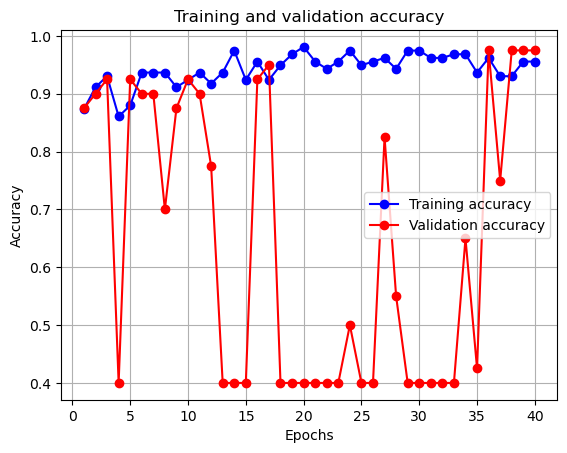

In [12]:
# Plot training & validation accuracy over epochs

acc     = history.history.get('accuracy') 
val_acc = history.history.get('val_accuracy')

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc    , 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Questions

Please fill in your answers below. 

**1. Take a look at Sample 10 and 30 of the dataset (prior to the split). How would you visually describe the difference between the seizure and non seziure sample? Based on what you learnt in the course, what operators could we use to discriminate between them?**

Your answer:

A lot of jitter for sample 30 while sample 10 less. 
One way of discriminating them would maybe be to normalize them/FFT then compare.
Or just note down the amplitude for each and then how many times it hits the peak and bottom. 
Seizure has more peaks and lows while non seizures are more fluxuating up and down, but lower peaks and higher lows than seizure.



**2. Calculate the standard deviation and mean of the training set after normalisation. Has Z-score normalisation been achieved? Why do we do this?**

Your answer:

std: 0.9999999999999998
mean: 2.349562176323017e-18

yes

**3. What do each of the layers represent in the visual representation of the neural network? Hint: Try commenting the layers.**

Your answer:



Circles are fully connected or convolutional networks
Bars are other functionality such as average pooling. 

**4. Implement dropout on the model. How does implementing dropout influence the final accuracy and model size? Would this increase training complexity, inference complexity or both?**

Your answer:

It does not increase model size because its only active during training, prevents overfitting and makes model more robust to non seen data. Ensuring trained accuarcy can hold for inference. 

---

## Arduino

In [13]:
from tinymlgen import port

- `tinymlgen` -> Converts a trained Keras model to a C header (we use its `port()` function).

### What is Arduino?

Arduino is a popular microcontroller platform that began with the Arduino UNO board and an easy-to-use C-based programming language and IDE. The Arduino ecosystem has since expanded to include a wide range of boards capable of running real-time operating systems, MicroPython, and even Docker containers, along with a comprehensive IoT suite with Edge AI capabilities.

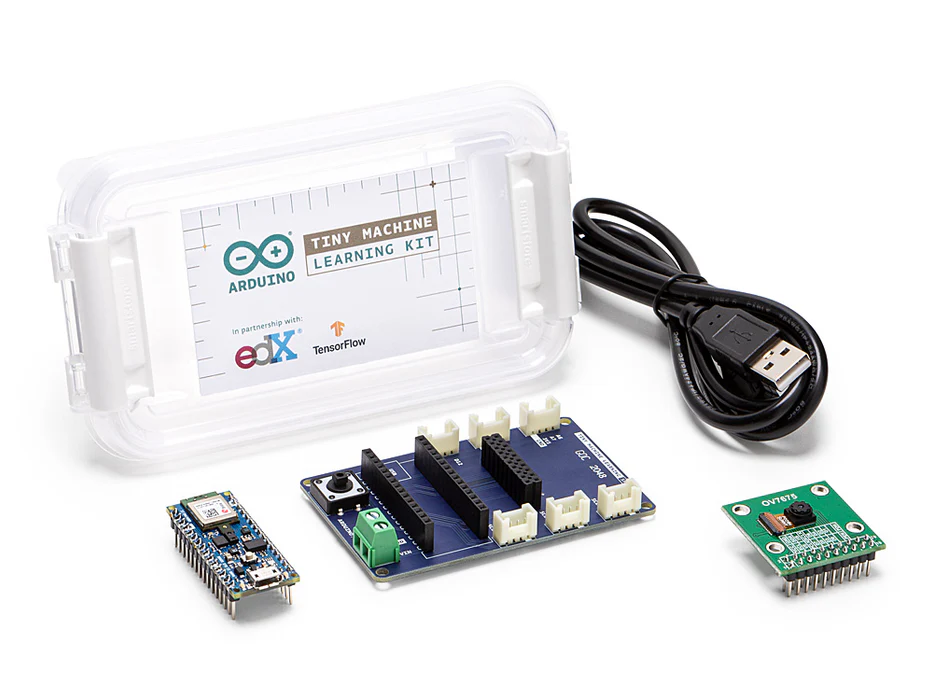

In this lab, we use the **Arduino Nano 33 BLE Sense** board and program it using the Arduino programming language (a simplified version of C/C++). The pinouts, datasheets, schematics and more for the Arduino Nano 33 BLE Sense can be found on the Arduino Docs website https://docs.arduino.cc/hardware/nano-33-ble-sense/ and is part of the Arduino Tiny ML Kit provided in the EITP40 course to students. You should be able to identify the microphone, IMU, temperature/humidity and RGB sensor IC on the Nano 33 BLE Sense. You can make use of these in your project.

### Creating a µC Friendly Model

<div class="alert alert-info">
📝 <b>TODO:</b> Create a lightweight model for Arduino deployment.
</div>

In [14]:
modelNN = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1024,)), 
    tf.keras.layers.Reshape((1024, 1)), 
    
    tf.keras.layers.Conv1D(32, 5, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv1D(64, 5, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.GlobalAveragePooling1D(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

modelNN.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Show model summary and parameter count
modelNN.summary()
print("Total trainable parameters:", modelNN.count_params())

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
]

history = modelNN.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=16,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 1024, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1024, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 512, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 512, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 256, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 256, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,866 (206.51 KB)

 Trainable params: 52,418 (204.76 KB)

 Non-trainable params: 448 (1.75 KB)

Total trainable parameters: 52866
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8799 - loss: 0.3723 - val_accuracy: 0.8000 - val_loss: 0.6261 - learning_rate: 0.0010
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9443 - loss: 0.1841 - val_accuracy: 0.9000 - val_loss: 0.6110 - learning_rate: 0.0010
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9037 - loss: 0.1891 - val_accuracy: 0.9000 - val_loss: 0.5904 - learning_rate: 0.0010
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9407 - loss: 0.1725 - val_accuracy: 0.9000 - val_loss: 0.5820 - learning_rate: 0.0010
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9111 - loss: 0.2421 - val_accuracy: 0.9000 - val_loss: 0.6141 - learning_rate: 0.0010
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9158 - loss: 0.1855 - val_accuracy: 0.9000 - val_loss: 0.6055 - learning_rate: 0.0010
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accurac

Verify that the validation accuracy is above 65% before continuing. If not, tweak the model, while paying attention to the model size. 

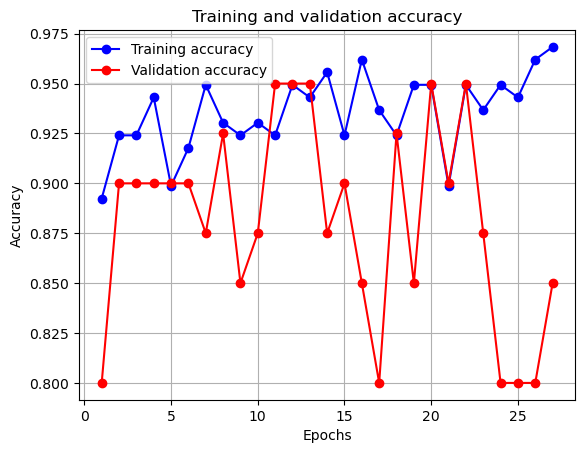

In [15]:
# Plot training & validation accuracy over epochs

acc     = history.history.get('accuracy') 
val_acc = history.history.get('val_accuracy')

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc    , 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Deploy to the Arduino

In [16]:
c_code = port(modelNN, variable_name='seizure_model', pretty_print=True,optimize=False)
filename = 'net.h'
with open(filename,'w') as f: 
    f.write(c_code)

INFO:tensorflow:Assets written to: /var/folders/v0/_6f0nk9d23z5x7cdts1h5vvm0000gn/T/tmpl19tpog1/assets


INFO:tensorflow:Assets written to: /var/folders/v0/_6f0nk9d23z5x7cdts1h5vvm0000gn/T/tmpl19tpog1/assets


Saved artifact at '/var/folders/v0/_6f0nk9d23z5x7cdts1h5vvm0000gn/T/tmpl19tpog1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1024), dtype=tf.float32, name='keras_tensor_15')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  12981533392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6427472720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6427474640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6427474256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6427472912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6427474448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6427474064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6427467344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6427473104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6427470992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6427470416: TensorSpec(

W0000 00:00:1764072561.717590  484471 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1764072561.718191  484471 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2025-11-25 13:09:21.719115: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/v0/_6f0nk9d23z5x7cdts1h5vvm0000gn/T/tmpl19tpog1
2025-11-25 13:09:21.719947: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-25 13:09:21.719952: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/v0/_6f0nk9d23z5x7cdts1h5vvm0000gn/T/tmpl19tpog1
2025-11-25 13:09:21.728940: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-11-25 13:09:21.730587: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-25 13:09:21.791197: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at 

A `net.h` file is generated, which includes a description of the model as well as the weights. Move it to the sketch folder, alongside the sketch.

### Test and Send to Kaggle

Install the Arduino 2.x IDE from the official website https://www.arduino.cc/en/software/, if not done already. From the dropdown list, select your OS and click on DOWNLOAD to obtain the stable version. Follow installation instructions. 

<div class="alert alert-info">
<b>NOTE:</b> For Lab 3 we are using the Arduino IDE, NOT the App Lab. If you do not see the link to download the IDE scroll down.
</div>

Open the `EITP40_Lab3_TinyML.ino` sketch. You will see a window similar to below.

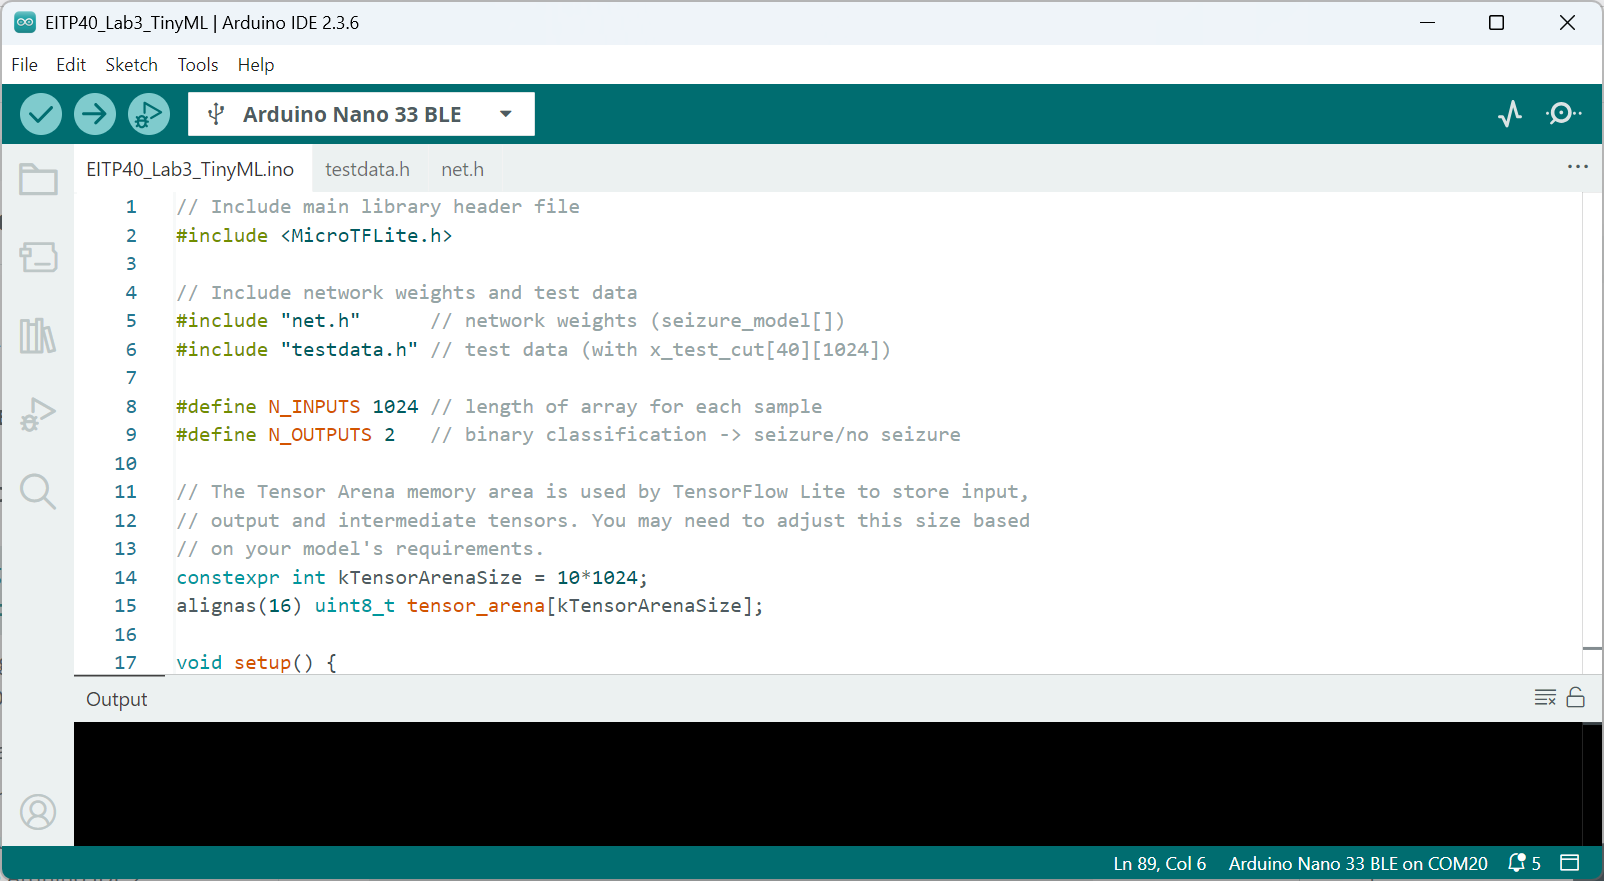



In addition to our main Arduino sketch `EITP40_Lab3_TinyML.ino`, there are two tabs for `testdata.h` and `net.h`. `testdata.h` includes a sample dataset of 40 examples with a feature length of 1024, while `net.h` is the same file we produced in the previous section from our Keras model.

The first line of code `#include <MicroTFLite.h>` is the main library used in this example. In the `setup()` function you can see the `ModelInit(seizure_model, tensor_arena, kTensorArenaSize)` method used to initialise the model upon board startup, which is borrowed from the `MicroTFLite` library. The library expands upon the now-retired [TFLite Micro library](https://github.com/tensorflow/tflite-micro-arduino-examples).

The `MicroTFLite` library is not included in the default installation of the Arduino IDE and needs to be installed manually. Make sure to install `MicroTFLite` and its dependancies in the IDE, if not done already. To check, click on the books to the left of the IDE and enter MicroTFLite in the search box. Lab 3 has been tested with MicroTFLite 1.0.4, Arduino Mbed OS Nano Boards 4.4.1 and Arduino IDE 2.3.6.

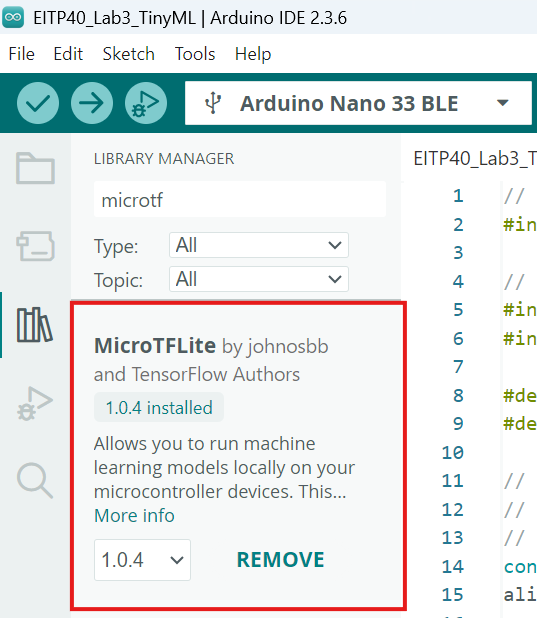

Connect the Arduino Nano 33 BLE Sense to the computer. Ensure that it is selected in the drop down menu (red rectangle), so that the Arduino IDE knows where to send the compiled code. Compile and upload the code (yellow rectangle).

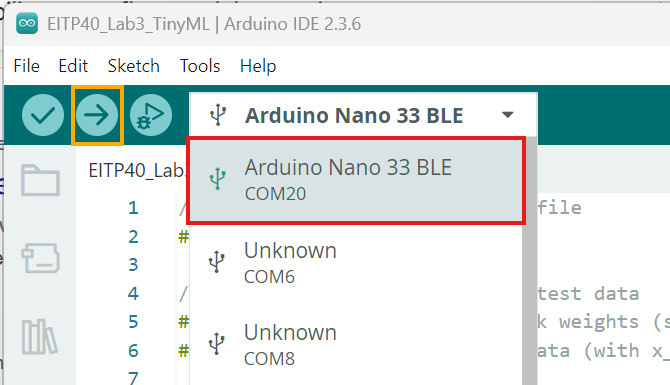

On first compilation, especially on Windows systems, it can take up to 10 minutes. After the compilation and then upload is complete, in the output window you will see a message similar to this.

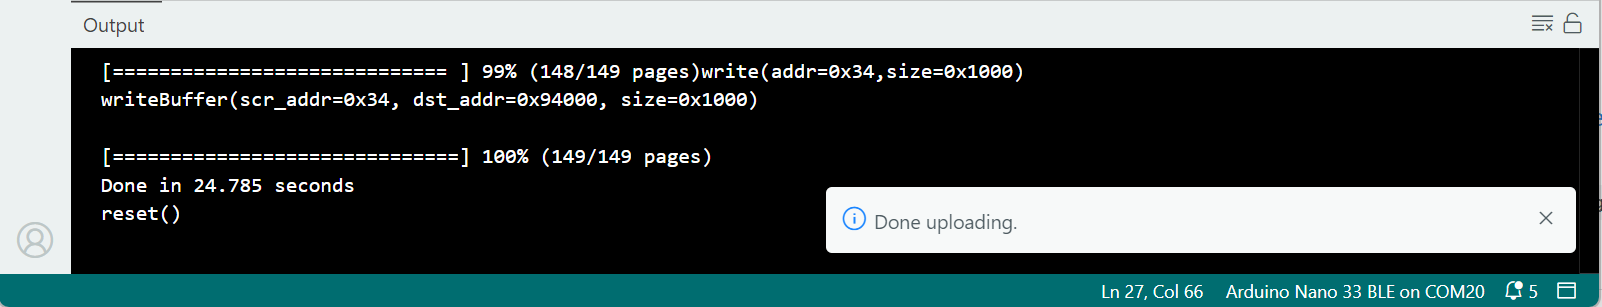

The Sketch is waiting for a serial connection (see `while (!Serial)`) to start the inference process and send the data. If it is not visible, open the Serial Monitor by selecting the Serial Monitor icon on the top right of the IDE. You will now see an additional tab next to the `Output` tab called `Serial Monitor`. 

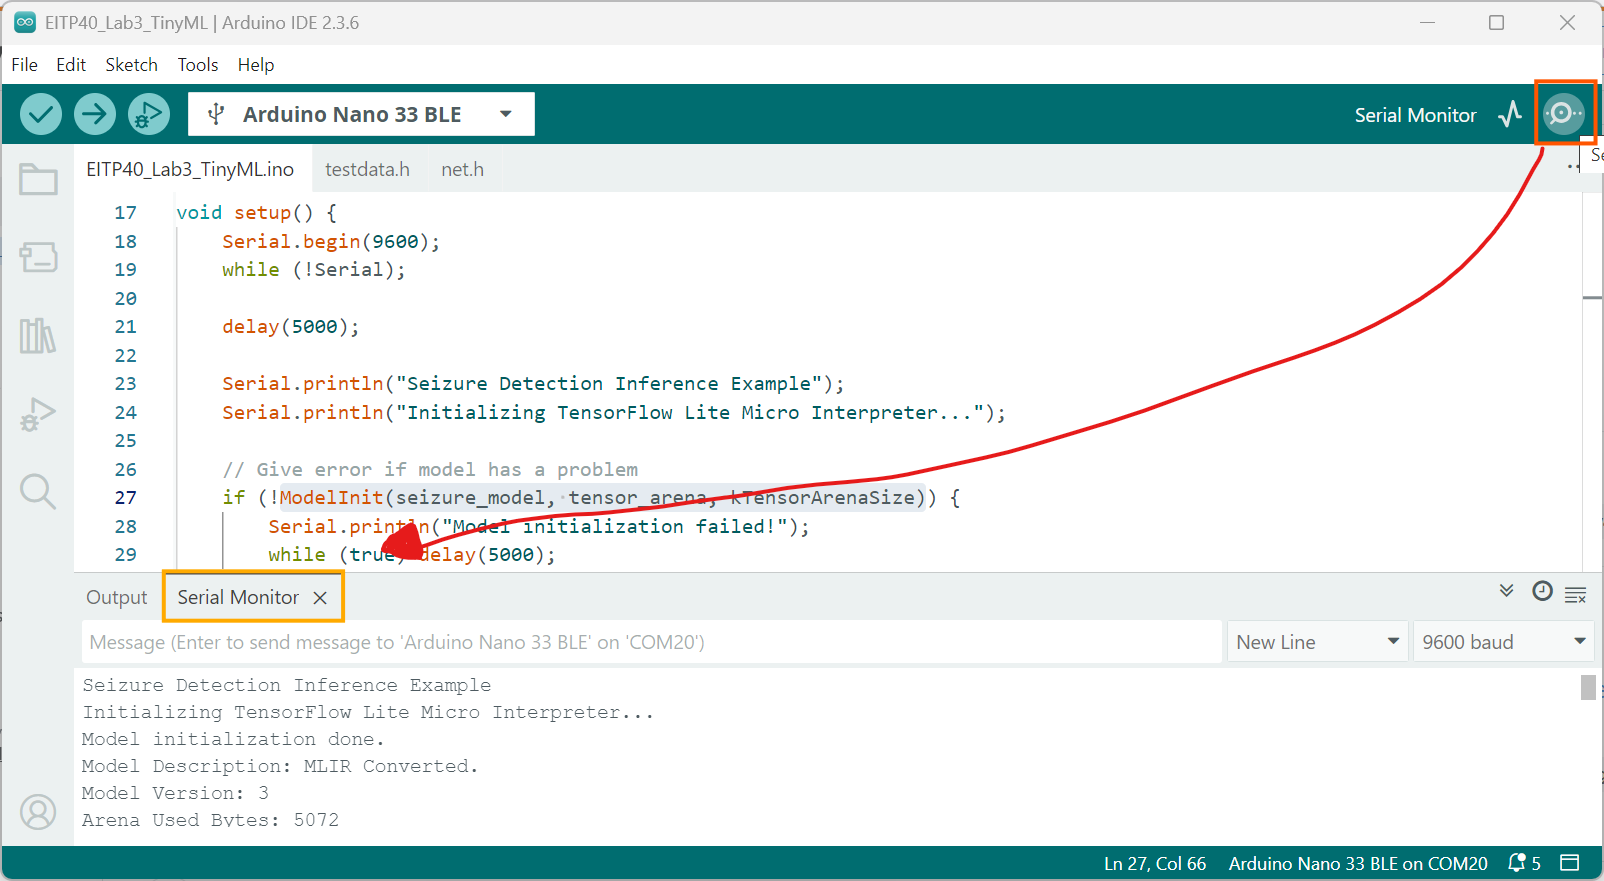

At the beginning of the Serial output, you can see diagnostic information. Then there is a list of data. 

```verbose
Seizure Detection Inference Example
Initializing TensorFlow Lite Micro Interpreter...
Model initialization done.
Model Description: MLIR Converted.
Model Version: 3
Arena Used Bytes: 5072
Input tensor dimensions: 2
Dimension 0: 1
Dimension 1: 1024
Output tensor dimensions: 2
Output Dimension 0: 1
Output Dimension 1: 2

Starting seizure detection on test data...
Id 	 Category 	 Time
1	0	0.006322
2	0	0.006301
3	0	0.006301
```

Copy the data, including the `Id   Category  Time` line up to (and including) the data for line 40. Save this as `submission.csv` and upload to the EITP40 Kaggle for Lab 3.

### Questions 


**1. Why can we not just send the same model in the first section and use it for inference on the Arduino Nano 33 BLE Sense? Make reference to the size of the model (`model_fc.summary())` and the memory of the Arduino Nano 33 BLE Sense.**

Your answer:

**2. Which number did you consider for TENSOR_ARENA_SIZE? Why? Please give the calculation based on [link](https://github.com/maarten-pennings/MachineLearning/blob/main/rock-paper-scissors/rock-paper-scissors.ipynb).**

Your answer:

**3. How can you optimise the process further, to be more efficient or more accurate?**

Your answer

**4. Have you encountered any problems (such as the output in Arduino Serial Monitoring is all `0`)? How did you solve it?**

Your answer:

---

# FAQ

<details>
<summary><strong>I get an error about <code>MicroTFLite.h</code> not being found</strong></summary>
<p>Install it via the Arduino IDE Library Manager.</p>
</details>

---

<details>
<summary><strong>I get the message <code>Output tensor index out of range!</code> in the Serial Monitor and/or all Category values are zero</strong></summary>
<p>Ensure that the model you made has a two-neuron output (e.g. final Dense layer with 2 units and softmax).</p>
</details>

---

<details>
<summary><strong>Where is the Serial Monitor?</strong></summary>
<p>It is located at the bottom of the Arduino IDE, in a tab next to the <code>Output</code> tab. If you do not see the tab, activate it by clicking on the magnifying glass over the dots on the top right corner.</p>
</details>

---

<details>
<summary><strong>Kaggle gives <code>ERROR: Required column 'Id'/'Category'/'Time' could not be found</code></strong></summary>
<p>The first line of your CSV file should include <code>Id  Category  Time</code> copied from the Serial Monitor.</p>
</details>

---

<details>
<summary><strong>I tried to compile, and I get the error <code>Compilation error: net.h: No such file or directory</code></strong></summary>
<p>Make sure that (a) you have generated the <code>net.h</code> file and (b) it is located in the same directory as the Arduino sketch.</p>
</details>

---

<details>
<summary><strong>I selected the tick button; lots happens in <code>Output</code>, but nothing is happening to the Arduino</strong></summary>
<p>Select the <strong>Upload</strong> button (to the right of the tick) to both compile and upload the Arduino sketch.</p>
</details>

---

<details>
<summary><strong>I do not see the option for <code>Arduino Nano 33 BLE</code> in the drop-down menu, or I get upload errors</strong></summary>
<p>Check that the USB cable is connected. You can also try putting the board in bootloader mode by double-tapping the <strong>RESET</strong> button while it is connected.</p>
</details>

---